# Clasificación en datasets desbalanceados - Regresión logística

### Introducción


El problema de los datasets desbalanceados ocurre cada vez que por algún motivo las clases que se desean identificar se observan con frecuencia muy diferente. Es una situación que se encuentra en una amplia variedad de problemas de Machine Learning. 

Existen dos grandes enfoques para abordar datasets que se encuentran desbalanceados:

1.  Hacer un resampling de la muestra, para entrenar al algoritmo con proporciones similares de las clases.
2.  Incorporar el desbalance a la función de costos del algoritmo para que tenga incentivos a elegir los parámetros que mejor discriminan la clase minoritaria.




A continuación presentamos un dataset de la empresa americana Lending Club, que se dedica a proveer servicios financieros para distintos segmentos. 

Vamos a utilizar información abierta del portal de la empresa para intentar predecir cuáles de los créditos terminan en default. Para más información sobre el datset pueden ingresar <a href='https://www.lendingclub.com/info/download-data.action'> aquí </a>

### Actualizar scikit-learn e Instalar imbalanced-learn

En esta práctica usaremos la librería imbalanced-learn. La instalamos con la siguiente linea:

!conda install --yes -c conda-forge imbalanced-learn==0.7
 
Pueden tener problemas con versiones de scikitlearn anteriores a 0.23. Entonces:

!conda install scikit-learn==0.23

o

!conda update scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

%matplotlib inline

In [2]:
loans = pd.read_csv('loans.csv')

In [3]:
loans.head()

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.00,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.00,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.00,8.25955,0
3,C,RENT,11,C1,0,20.00,36 months,other,13.49,0,1,21.0,16.97,8.27585,0
4,A,RENT,4,A4,0,11.20,36 months,wedding,7.90,1,1,28.3,0.00,5.21533,0



## Análisis exploratorio


#### Balance de la clase

La clase que vamos a intentar predecir es "bad loans" que indica si el préstamo fue pagado a tiempo o no. Observamos que la clase está desbalanceada, la mayoría de los préstamos se pagan a tiempo.

In [4]:
loans['bad_loans'].value_counts(normalize=True)

0    0.811185
1    0.188815
Name: bad_loans, dtype: float64

#### Valores faltantes

Inspeccionamos los valores faltantes

In [5]:
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        4
bad_loans                0
dtype: int64

Eliminamos las entradas nulas

In [6]:
loans.dropna(inplace=True);
loans.reset_index(drop=True,inplace=True)
loans.isnull().sum()

grade                    0
home_ownership           0
emp_length_num           0
sub_grade                0
short_emp                0
dti                      0
term                     0
purpose                  0
int_rate                 0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
payment_inc_ratio        0
bad_loans                0
dtype: int64

## Regresión logística

Vamos a utilizar Regresión Logística para predecir la clase bad_loans. 

In [7]:
loans.shape

(122603, 15)

### Variables dummy

Generamos las variables dummies para los datos categóricos. 

In [8]:
# Generamos las variables dummies para los datos categóricos.
loans_dummy = pd.get_dummies(loans,drop_first=True);

In [9]:
loans_dummy.dtypes

emp_length_num              int64
short_emp                   int64
dti                       float64
int_rate                  float64
last_delinq_none            int64
                           ...   
purpose_moving              uint8
purpose_other               uint8
purpose_small_business      uint8
purpose_vacation            uint8
purpose_wedding             uint8
Length: 65, dtype: object

In [10]:
loans.columns

Index(['grade', 'home_ownership', 'emp_length_num', 'sub_grade', 'short_emp',
       'dti', 'term', 'purpose', 'int_rate', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'payment_inc_ratio', 'bad_loans'],
      dtype='object')

In [11]:
loans.head(3)

,grade,home_ownership,emp_length_num,sub_grade,short_emp,dti,term,purpose,int_rate,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,payment_inc_ratio,bad_loans
0,B,RENT,11,B2,0,27.65,36 months,credit_card,10.65,1,1,83.7,0.0,8.14350,0
1,C,RENT,1,C4,1,1.00,60 months,car,15.27,1,1,9.4,0.0,2.39320,1
2,C,RENT,11,C5,0,8.72,36 months,small_business,15.96,1,1,98.5,0.0,8.25955,0


#### Train test split


In [12]:
X_train, X_test, y_train, y_test\
                            = train_test_split(loans_dummy.drop(['bad_loans'], axis=1),\
                                    loans_dummy['bad_loans'],\
                                    stratify = loans_dummy['bad_loans'],\
                                    random_state=0)

In [13]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (91952, 64)
Testeo: (30651, 64)

Clases train:
0    0.811184
1    0.188816
Name: bad_loans, dtype: float64

Clases test:
0    0.811164
1    0.188836
Name: bad_loans, dtype: float64


### Regresión logística

La siguiente función implementa una regresión logística optimizando el hiperparámetro de regularización por cross validation.

Luego imprime las métricas principales de evaluación en problemas de clasificación.

In [14]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

    return
    

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     24863
           1       0.47      0.02      0.05      5788

    accuracy                           0.81     30651
   macro avg       0.64      0.51      0.47     30651
weighted avg       0.75      0.81      0.73     30651

Area bajo la curva ROC: 0.689
Area bajo la curva Precision-Recall: 0.3252


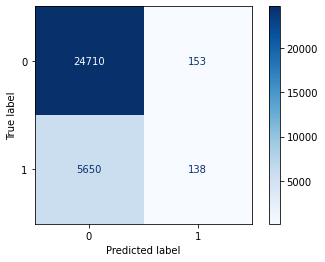

In [15]:
logistic_regression_report(X_train,X_test,y_train,y_test)

Vemos que el modelo tiene una accuracy de 0.81. Los valores de precision y recall nos muestran que el modelo es bueno prediciendo la clase mayoritaria pero es muy malo para la clase minoritaria. 



Vamos a implementar tres posibles soluciones al problema del desbalance de clases:<b> Undersampling, Oversampling, Class weighting</b>

Para resamplear los datos utilizaremos la librería <b>imblearn</b>



## Undersampling


Una estrategia posible es entrenar un modelo en un subset de datos con clases balanceadas, descartando casos de la clase mayoritaria. Para esto utilizaremos la clase RandomUnderSampler que samplea observaciones de la clase mayoritaria al azar, con o sin reposición.

El hiperparámetro **sampling_strategy** sirve para definir la estrategia de sampleo. La opción 'majority' seleccionará un número de muestras igual al de la clase minoritaria. También se puede pasar un valor numérico entre cero y uno que represnte el ratio entre la clase mayoritaria y la minoritaria.

[Documentación](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

In [17]:
undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())


Composición del training set:
0    17362
1    17362
Name: bad_loans, dtype: int64

Composición del test set:
0    24863
1     5788
Name: bad_loans, dtype: int64


              precision    recall  f1-score   support

           0       0.88      0.63      0.74     24863
           1       0.29      0.64      0.40      5788

    accuracy                           0.63     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.63      0.67     30651

Area bajo la curva ROC: 0.6876
Area bajo la curva Precision-Recall: 0.3238


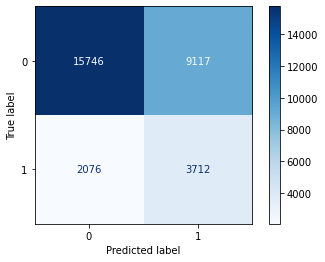

In [21]:
logistic_regression_report(X_train_us, X_test, y_train_us, y_test)


Vemos que el modelo hace un mejor trabajo en reconocer a la clase minoritaria. 

## Oversampling

Para aumentar la representación de la clase minoritaria vamos a hacer un oversampling. Una estrategia posible es usar la herramienta RandomOversampler, que funciona de manera análoga a RandomUndersampler. En este caso, el método consiste en samplear observaciones de la clase minoritaria con reposición.

El hiperparámetro **sampling_strategy** puede tomar los valores:

* 'minority': samplea hasta balancear las clases
* número entre 0 y 1: ratio entre las clases mayoritaria y minoritaria

[Documentación](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html)


In [22]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    74590
0    74590
Name: bad_loans, dtype: int64

Composición del test set:
0    24863
1     5788
Name: bad_loans, dtype: int64


              precision    recall  f1-score   support

           0       0.88      0.63      0.74     24863
           1       0.29      0.65      0.40      5788

    accuracy                           0.63     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.63      0.67     30651

Area bajo la curva ROC: 0.6885
Area bajo la curva Precision-Recall: 0.3247


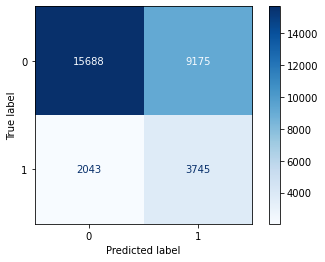

In [23]:
logistic_regression_report(X_train_os,X_test,y_train_os,y_test)

## Class weighting

Otra técnica que podemos utilizar para corregir el desbalance de los datos es incorporar en la función de costos del algoritmo un mayor peso para los errores de entrenamiento cometidos sobre los puntos de la clase minoritaria. 

La regresión logística admite el argumento "class_weight" para ponderar la contribución a la función de costo de cada clase. Si usamos class_weight = 'balanced' los pesos asignados son la inversa de la frecuencia con que se observa cada clase.


In [24]:
model = LogisticRegressionCV(class_weight = 'balanced')

scaler=StandardScaler()

X_train_sc=scaler.fit_transform(X_train);
X_test_sc=scaler.transform(X_test);

model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)
pred_probas = model.predict_proba(X_test_sc);

              precision    recall  f1-score   support

           0       0.88      0.64      0.74     24863
           1       0.29      0.64      0.40      5788

    accuracy                           0.64     30651
   macro avg       0.59      0.64      0.57     30651
weighted avg       0.77      0.64      0.68     30651

Area bajo la curva ROC: 0.6866497653860503
Area bajo la curva Precision-Recall: 0.32409089241254496


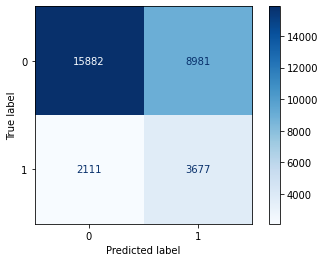

In [25]:
print(classification_report(y_test,y_pred))
plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);

print('Area bajo la curva Precision-Recall:',auc(recall,precision))